In [112]:
import cv2 as cv
import numpy as np
import random
import copy
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display(img):
    return Image.fromarray(img)

In [3]:
def place_above(canvas, dot, num_coords):

    top_left_row = num_coords['min_col'] + random.randint(-20, 20)
    top_left_col = num_coords['min_row'] - dot.shape[0] - random.randint(0, 10)

    return top_left_row, top_left_col 

def place_below(canvas, num, dot_coords):
        
    top_left_col = dot_coords['max_row'] + random.randint(0, 10)
    top_left_row = dot_coords['min_col'] + random.randint(-20, 20)
    
    return top_left_row, top_left_col

def place_right(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['max_col'] + random.randint(0, 10)
    
    return top_left_row, top_left_col

def place_left(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return top_left_row, top_left_col

def totally_inside_paper(top_left_obj, obj, canvas):

    for corner in get_corners(top_left_obj, obj):
         if cv.pointPolygonTest(canvas.contours, (corner[1], corner[0]), False) < 0.0:
                return False
    
    return True

In [208]:
image_samples = []

canvas_sampler = Sampler(get_canvases('canvases'))
dot_sampler = Sampler(get_img_data('dots'))
background_sampler = Sampler(get_img_data('backgrounds'))

num_sampler = [None]

for i in range(1,3):
    imgs = get_img_data('nums/' + str(i))
    num_sampler.append(Sampler(imgs))

num_of_samples = 5

for i in range(num_of_samples):
    canvas = copy.deepcopy(canvas_sampler.get_sample())
    bboxs = {}
    
    nums_on_paper = random.randint(0, 20)
    
    for i in range(nums_on_paper):
        cur_num = random.randint(1,2)
        num = num_sampler[cur_num].get_sample()
        scalar = random.uniform(.8, 1)
        num = cv.resize(num, (int(num.shape[0]*scalar), int(num.shape[1]*scalar)))
        num = adaptive_thresh(num)
        
        x1 = random.randint(canvas.top_left[0],  canvas.top_right[0])
        y1 = random.randint(canvas.top_left[1],  canvas.bot_left[1])

        while not canvas.draw_on_paper(num, (x1, y1)):
            x1 = random.randint(canvas.top_left[0],  canvas.top_right[0])
            y1 = random.randint(canvas.top_left[1],  canvas.bot_left[1])

        top_left, top_right, bot_right, bot_left = get_corners((x1, y1), num)
        
        if cur_num not in bboxs:
            bboxs[cur_num] = []
            
        bboxs[cur_num].append((top_left, top_right, bot_right, bot_left))

        num_coords = {}
        num_coords['min_row'] = top_left[1]
        num_coords['max_row'] = bot_right[1]
        num_coords['min_col'] = top_left[0]
        num_coords['max_col'] = bot_right[0]

        np.random.shuffle(func)
        
        scalar = .8   
        dot = dot_sampler.get_sample()
        dot = cv.resize(dot, ( int(dot.shape[0]*scalar), int(dot.shape[1]*scalar)))
        dot = adaptive_thresh(dot)

        for f in func:
            top_left = f(a, dot, num_coords)
            if canvas.draw_on_paper(dot, top_left):
                if 'dots' not in bboxs:
                    bboxs['dots'] = []
                    
                bboxs['dots'].append(get_corners(top_left, dot))
                break
    
    deg = 10
    
    org_shape = canvas.img.shape
    canvas.rotate(deg)
    
    rad = np.deg2rad(deg)
    rt = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])

    for k,v in bboxs.items():
        for obj in v:
            nw = np.dot(rt, np.array(obj).T - (np.array(org_shape[::-1])/2).reshape(2,-1)) + np.array([canvas.img.shape[1]/2, canvas.img.shape[0]/2]).reshape(2,-1)
           # nw = np.dot(rt, np.array(obj).T - np.array([1280/2, 720/2]).reshape(2,-1)) + np.array([canvas.img.shape[1]/2, canvas.img.shape[0]/2]).reshape(2,-1)

            nw = nw.astype(np.int32)

            canvas.img = cv.rectangle(canvas.img, tuple(nw[:, 0]), tuple(nw[:, 2]), (0), 1)

    background_count = random.randint(0, 5)
    for i in range(background_count):
 
        background = background_sampler.get_sample()
        scalar = random.uniform(1, 1)
        background = cv.resize(background, (int(background.shape[0]*scalar), int(background.shape[1]*scalar)))
        background = adaptive_thresh(background)
        
        y1 = random.randint(0, canvas.img.shape[0])
        x1 = random.randint(0, canvas.img.shape[1])

        while(totally_inside_paper((x1, y1), background, canvas)):
            y1 = random.randint(0, canvas.img.shape[0])
            x1 = random.randint(0, canvas.img.shape[1])

        canvas.draw_on_background(background, (x1, y1))
        
    image_samples.append(canvas.img)    

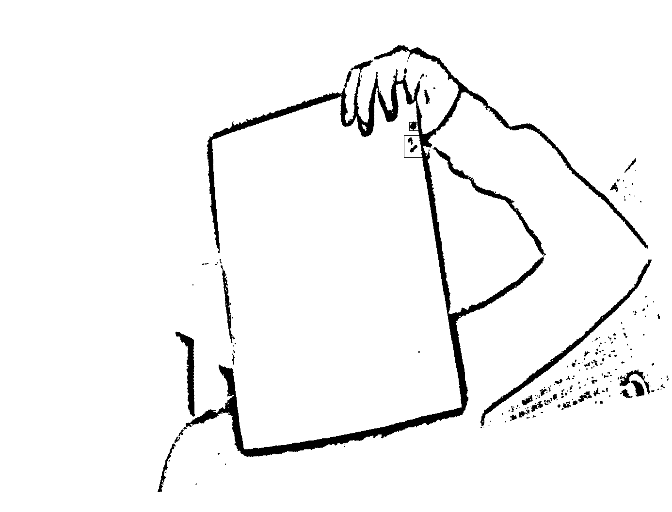

In [211]:
display(cv.resize(image_samples[2], (672, 512)))    